In [419]:
import pandas as pd
from Bio import SeqIO

In [420]:
dbaasp_df = pd.read_csv('dbaasp_amps.csv', header=0)
print(dbaasp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19847 entries, 0 to 19846
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              19847 non-null  int64 
 1   COMPLEXITY      19847 non-null  object
 2   NAME            16701 non-null  object
 3   N TERMINUS      2640 non-null   object
 4   SEQUENCE        19847 non-null  object
 5   C TERMINUS      9601 non-null   object
 6   SYNTHESIS TYPE  19847 non-null  object
 7   TARGET GROUP    557 non-null    object
 8   TARGET OBJECT   532 non-null    object
dtypes: int64(1), object(8)
memory usage: 1.4+ MB
None


There are only 557 amps with labeled targetting groups, yet the dataset was filtered before download, thus all proteins inside target bacteria, and this is just an error of dataset provider.

In [422]:
records = list(SeqIO.parse("dbamp_antibacterial.fasta", "fasta"))

data = {
    "ID": [record.id for record in records],
    "Description": [record.description for record in records],
    "Sequence": [str(record.seq) for record in records],
    "Length": [len(record.seq) for record in records]
}

dbamp_df = pd.DataFrame(data)
print(dbamp_df)

               ID  Description  \
0     dbAMP_00001  dbAMP_00001   
1     dbAMP_00005  dbAMP_00005   
2     dbAMP_00006  dbAMP_00006   
3     dbAMP_00023  dbAMP_00023   
4     dbAMP_00024  dbAMP_00024   
...           ...          ...   
7620  dbAMP_34523  dbAMP_34523   
7621  dbAMP_34524  dbAMP_34524   
7622  dbAMP_34525  dbAMP_34525   
7623  dbAMP_34526  dbAMP_34526   
7624  dbAMP_34527  dbAMP_34527   

                                               Sequence  Length  
0           AAAAGSVWGAVNYTSDCNGECKRRGYKGGYCGSFANVNCWCET      43  
1              AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC      40  
2     AAEFPDFYDSEEQMGPHQEAEDEKDRADQRVLTEEEKKELENLAAM...      60  
3     AAFFAQQKGLPTQQQNQVSPKAVSMIVNLEGCVRNPYKCPADVWTN...     169  
4                                     AAFRGCWTKNYSPKPCL      17  
...                                                 ...     ...  
7620  AHDRNPLEECFRETDYEEFLEIAKNGLTATSNPKRVVIVGAGMAGL...     498  
7621  ATNSSEAFIESIAASAKPVADANGLYPSVMIAQAILESNWGSSQLS...     380

From DBamp database only 7625 entries are present, yet close enough to 10k and having in mind that upper dataset is enormous I will proceed.

In [424]:
dramp_df = pd.read_excel('dramp_amps.xlsx', header=0)
print(dramp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11612 entries, 0 to 11611
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   DRAMP_ID                 11611 non-null  object
 1   Sequence                 11612 non-null  object
 2   Sequence_Length          11612 non-null  int64 
 3   Name                     11537 non-null  object
 4   Swiss_Prot_Entry         11609 non-null  object
 5   Family                   7679 non-null   object
 6   Gene                     11478 non-null  object
 7   Source                   11582 non-null  object
 8   Activity                 11612 non-null  object
 9   Protein_existence        11355 non-null  object
 10  Structure                11611 non-null  object
 11  Structure_Description    11612 non-null  object
 12  PDB_ID                   4310 non-null   object
 13  Comments                 11612 non-null  object
 14  Target_Organism          11605 non-nul

In [425]:
antib_dramp_df = dramp_df[dramp_df['Activity'].str.contains(r'\bAntimicrobial\b', regex=True)]
print(antib_dramp_df)

         DRAMP_ID                                           Sequence  \
0      DRAMP00005                     SLGPAIKATRQVCPKATRFVTVSCKKSDCQ   
1      DRAMP00017                           VTSWSLCTPGCTSPGGGSNCSFCC   
2      DRAMP00032                           GNGVLKTISHECNMNTWQFLFTCC   
3      DRAMP00063                              SSSGWLCTLTIECGTIICACR   
4      DRAMP00068  MSWLNFLKYIAKYGKKAVSAAWKYKGKVLEWLNVGPTLEWVWQKLK...   
...           ...                                                ...   
11607  DRAMP35986                                        LLLLLLLLLLL   
11608  DRAMP35987                            LLLLLLLLLLLLLLLLLLLLLLL   
11609  DRAMP35988              LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL   
11610  DRAMP35989              LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL   
11611  DRAMP35990                                 GAGIVVASIDTGVRVSHE   

       Sequence_Length                                    Name  \
0                   30              Epicidin 280 (Bacteriocin)   
1  

Now that all three datasets are read and checked for antimicrobial acitivty, I shall proceed with normalization

In [427]:
def process_dataframe(df, name_col, seq_col, len_col=None):
    """
    Standardizes dataframe columns and calculates sequence length if needed. Remove duplicates
    
    Args:
        df: Input DataFrame
        name_col: Column name for peptide names
        seq_col: Column name for sequences
        len_col: Optional existing length column
    
    Returns:
        Standardized DataFrame with ['NAME', 'SEQUENCE', 'SEQUENCE_LENGTH']
    """
    processed = df[[name_col, seq_col]].copy()
    processed.columns = ['NAME', 'SEQUENCE']
    
    if len_col:
        processed['SEQUENCE_LENGTH'] = df[len_col]
    else:
        processed['SEQUENCE_LENGTH'] = processed['SEQUENCE'].str.len()
    
    duplicate_count = processed.duplicated(subset=['SEQUENCE']).sum()
    print(f"Found {duplicate_count} duplicate sequences, keeping first occurrence")
    print(f"Exemplary duplicates: \n{processed[processed.duplicated(subset=['SEQUENCE'], keep=False)].sort_values('SEQUENCE')}")
    processed = processed.drop_duplicates(subset=['SEQUENCE'], keep='first')
    deleted_sum = len(df) - len(processed)
    print(f"\n removed duplicates: {deleted_sum}")
    
    return processed, deleted_sum

sources = [
    (dbaasp_df, 'NAME', 'SEQUENCE', None),
    (dbamp_df, 'Description', 'Sequence', 'Length'),
    (antib_dramp_df, 'Name', 'Sequence', 'Sequence_Length')
]

processed_dfs = {}
sum_deleted = 0
for i, (df, name_col, seq_col, len_col) in enumerate(sources, 1):
    print(f"\nProcessing dataset {i}:")
    processed, removed = process_dataframe(df, name_col, seq_col, len_col)
    print(processed.head(2))
    sum_deleted = sum_deleted + removed
    processed_dfs[f"dataset_{i}"] = processed
positive_amps_df = pd.concat(processed_dfs.values(), ignore_index=True)
positive_amps_df, removed = process_dataframe(positive_amps_df, 'NAME', 'SEQUENCE', 'SEQUENCE_LENGTH')
sum_deleted = sum_deleted + removed
print(f"\n Sum of duplicates removed: {sum_deleted}")
positive_amps_df['CLASSIFICATION'] = 1
print(f"final positive amps dataset: {positive_amps_df}")


Processing dataset 1:
Found 2614 duplicate sequences, keeping first occurrence
Exemplary duplicates: 
                                        NAME             SEQUENCE  \
10383                                   A4R4             AAAARRRR   
10384                                 [A4R4]             AAAARRRR   
11355                            Kunitzin-RE    AAKIILNPKFRCKAAFC   
8013                             Kunitzin-RE    AAKIILNPKFRCKAAFC   
9809   C14-HBD-1 (16-36) [C27,35Del], MPhd-1  ACPIFTKIQGTYRGKAKCK   
...                                      ...                  ...   
18123                         Tripropeptin A             xpPRXSXx   
18122                         Tripropeptin C             xpPRXSXx   
18126                         Tripropeptin Z             xpPRXSXx   
17150                                WCopW10         xwllwiglrkkr   
17149                                 WCopW9         xwllwiglrkkr   

       SEQUENCE_LENGTH  
10383                8  
10384             

At this point I have got combined dataset of positive amps without duplicates regarding sequences.

Next step is to remove sequences with unusual aminoacids.

In [430]:
import pandas as pd
import re

def remove_non_standard_sequences(df):
    
    STANDARD_AAS = set("ACDEFGHIKLMNPQRSTVWY")
    
    
    df["SEQUENCE"] = df["SEQUENCE"].str.upper().str.replace(" ", "")
    
    valid_mask = df["SEQUENCE"].str.fullmatch(
        r"^[ACDEFGHIKLMNPQRSTVWY]+$",
        na=False
    )
    
    df_clean = df[valid_mask].copy()
    invalid_seqs = df[~valid_mask]

    print(f"Removed {len(invalid_seqs)} invalid sequences:")
    print(invalid_seqs)
    print("\nValid sequences:")
    return df_clean
    
positive_amps_df = remove_non_standard_sequences(positive_amps_df)
print(positive_amps_df)

Removed 3798 invalid sequences:
                                     NAME  \
9                                    RNal   
18                Lantibiotic Enterocin W   
43     NC7- Dermaseptin S4 (2-15)AMD[M4K]   
45     NC7- Dermaseptin S4 (3-15)AMD[M4K]   
47     NC7- Dermaseptin S4 (4-15)AMD[M4K]   
...                                   ...   
35050                                 NaN   
35092                          Galaxamide   
35093                Galaxamide [MeLeu4P]   
35122                          PMI-HIF1-1   
35160                             PMAP-NC   

                                                SEQUENCE  SEQUENCE_LENGTH  \
9                                                 RRXXRF                6   
18     KCPWWNLSCHLGNDGKICTYSHECTAGCNVXTXIPCXVMVSAAVCP...               62   
43                                       XLWKTLLKKVLKAAA               15   
45                                        XWKTLLKKVLKAAA               14   
47                                        

After removing unusual sequences let's proceed with filtering by range of length.

In [432]:

in_range = positive_amps_df["SEQUENCE"].str.len().between(10, 50)
out_of_range = ~in_range

positive_amps_df_in_range = positive_amps_df[in_range]
positive_amps_df_out_of_range = positive_amps_df[out_of_range]

print("Sequences removed:")
print(positive_amps_df_out_of_range)
print("\nDataset after filtering:")
print(positive_amps_df_in_range)

positive_amps_df = positive_amps_df_in_range.copy()

Sequences removed:
                                            NAME  \
3                                    Enterocin X   
5      Lactococcin-Q alpha + Lactococcin-G alpha   
6                                            NaN   
13                     Bacteriocin Lactococcin-Q   
14                     Bacteriocin Lactococcin-G   
...                                          ...   
35151                                     CD9-BP   
35153                                         P1   
35154                                         P2   
35158                                        NaN   
35159                                        NaN   

                                                SEQUENCE  SEQUENCE_LENGTH  \
3      SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILGIAPIIV...               81   
5      SIWGDIGQGVGKAAYWVGKAMGNMSDVNQASRINRKKKHGTWDDIG...               82   
6                                                 LFIFFF                6   
13     SIWGDIGQGVGKAAYWVGKAMGNMSDVNQASRINRKKKHKK

After above procedures the dataset got almost halfed. 18210 entries are present right now. That was the last step, so the count of the sequences is final.

NEGATIVE DATASET

In [436]:
up_amps_df = pd.read_csv('uniprot_negative_amps.tsv', sep='\t', header=0)
print(up_amps_df)

            Entry    Reviewed        Entry Name  \
0      A0A087WZT3  unreviewed  A0A087WZT3_HUMAN   
1      A0A0C5B5G6    reviewed       MOTSC_HUMAN   
2      A0A2R8VHR8    reviewed       DT3UO_MOUSE   
3          A6IP77  unreviewed        A6IP77_RAT   
4          B7SCJ2  unreviewed        B7SCJ2_RAT   
...           ...         ...               ...   
60822      X6RBI5  unreviewed      X6RBI5_HUMAN   
60823      X6RHZ2  unreviewed      X6RHZ2_HUMAN   
60824      Z4YMU7  unreviewed      Z4YMU7_MOUSE   
60825      Z4YN31  unreviewed      Z4YN31_MOUSE   
60826      Z4YN77  unreviewed      Z4YN77_MOUSE   

                                           Protein names           Gene Names  \
0                               BOLA2-SMG1P6 readthrough         BOLA2-SMG1P6   
1      Mitochondrial-derived peptide MOTS-c (Mitochon...              MT-RNR1   
2      DDIT3 upstream open reading frame protein (Alt...                Ddit3   
3      CASP8 and FADD-like apoptosis regulator, isofo...      C

In [437]:
up_amps_df_filtered, sum_of_removed = process_dataframe(up_amps_df, 'Protein names', 'Sequence', 'Length')
print(f"Total number of duplicates removed: {sum_of_removed}")
print(up_amps_df_filtered)

Found 14576 duplicate sequences, keeping first occurrence
Exemplary duplicates: 
                                      NAME  \
46084  Mitochondrial ribosomal protein S35   
10393                     MRPS35 isoform 3   
12497                     TMEM62 isoform 6   
13241                     TMEM62 isoform 9   
46595             Transmembrane protein 62   
...                                    ...   
7977                          Cytochrome b   
29022                         Cytochrome b   
7970                          Cytochrome b   
29009                         Cytochrome b   
29014                         Cytochrome b   

                                                SEQUENCE  SEQUENCE_LENGTH  
46084             AAAALPAWLSLQSRARTLRAFSTAVYSATPVPTPSLQY               38  
10393             AAAALPAWLSLQSRARTLRAFSTAVYSATPVPTPSLQY               38  
12497  AAAALVAMLLEHYGLAGQPSPLPRPAPPRRPHPAPGPGDSNIFWGLQET               49  
13241  AAAALVAMLLEHYGLAGQPSPLPRPAPPRRPHPAPGPGDSNIFWGLQET      

After normalization of features and deletion of duplcates let's remove unwanted sequences

In [439]:
up_amps_df_filtered = remove_non_standard_sequences(up_amps_df_filtered)
print(up_amps_df_filtered)

Removed 2453 invalid sequences:
                                                    NAME  \
19     Fibroblast growth factor 1 (FGF-1) (Acidic fib...   
27     Beta-1,4-galactosyltransferase 1 (Beta-1,4-Gal...   
76     Ribonuclease pancreatic (EC 4.6.1.18) (RNase 1...   
78     Calreticulin (CRP55) (Calregulin) (Endoplasmic...   
86     Small nuclear ribonucleoprotein Sm D2 (Sm-D2) ...   
...                                                  ...   
60647           Abhydrolase domain-containing protein 11   
60651           Abhydrolase domain-containing protein 11   
60668  Signal transducer and activator of transcripti...   
60711                                        Thyrotropin   
60781                         AKT1m transcript variant 3   

                                                SEQUENCE  SEQUENCE_LENGTH  
19                                       NYMKPKLLYXSNGGH               15  
27                      PGATLQXAXXLLVAVXAXPPPPLGVXPKPXPG               32  
76                 

Make sure that all sequences have length in range [10,50]

In [441]:
negative_amps_df_out_of_range = up_amps_df_filtered.query("1 <= SEQUENCE_LENGTH < 10 or 50 < SEQUENCE_LENGTH")
print(negative_amps_df_out_of_range)

Empty DataFrame
Columns: [NAME, SEQUENCE, SEQUENCE_LENGTH]
Index: []


There are none. Let's add a classification column.

In [443]:
up_amps_df_filtered['CLASSIFICATION'] = 0
negative_amps_df = up_amps_df_filtered
print(negative_amps_df)

                                                    NAME  \
0                               BOLA2-SMG1P6 readthrough   
1      Mitochondrial-derived peptide MOTS-c (Mitochon...   
2      DDIT3 upstream open reading frame protein (Alt...   
3      CASP8 and FADD-like apoptosis regulator, isofo...   
4                                           Kit oncogene   
...                                                  ...   
60818                       Hydroxymethylbilane synthase   
60820                                         Histatin 3   
60824        Proline-rich nuclear receptor coactivator 2   
60825  Alpha-N-acetylgalactosaminide alpha-2,6-sialyl...   
60826               SANT and BTB domain regulator of CSR   

                                               SEQUENCE  SEQUENCE_LENGTH  \
0          MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS               44   
1                                      MRWQEMGYIFYPRKLR               16   
2                    MLKMSGWQRQSQNNSRNLRRECSRRKCIFI

Plotting the sequence lengths distribution

In [445]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sequence_length_distribution(df, sequence_col='SEQUENCE', 
                                    title='Sequence Length Distribution',
                                    color='skyblue', bin_width=5,
                                    figsize=(10, 6),
                                    save_dir='figures'):
    """
    Plots and saves the distribution of sequence lengths.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    df = df.copy()
    df['LENGTH'] = df[sequence_col].str.len()
    
    plt.figure(figsize=figsize)
    ax = sns.histplot(data=df, x='LENGTH', 
                     bins=range(0, df['LENGTH'].max()+bin_width, bin_width),
                     color=color, kde=True, stat='percent')
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Sequence Length (amino acids)', fontsize=12)
    plt.ylabel('Percentage of Sequences (%)', fontsize=12)
    
    mean_len = df['LENGTH'].mean()
    plt.axvline(mean_len, color='red', linestyle='--', linewidth=1)
    plt.text(mean_len+1, plt.ylim()[1]*0.9, f'Mean: {mean_len:.1f}', color='red')
    
    stats_text = f"Total: {len(df):,}\nMin: {df['LENGTH'].min()}\nMax: {df['LENGTH'].max()}\nMedian: {df['LENGTH'].median():.1f}"
    plt.gcf().text(0.72, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    filename = f"{title.lower().replace(' ', '_')}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

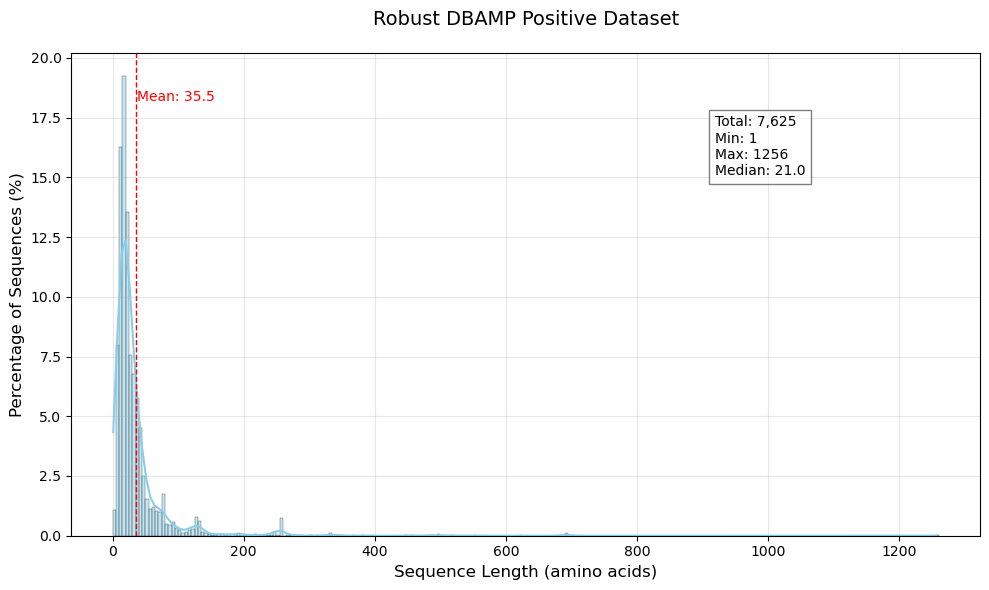

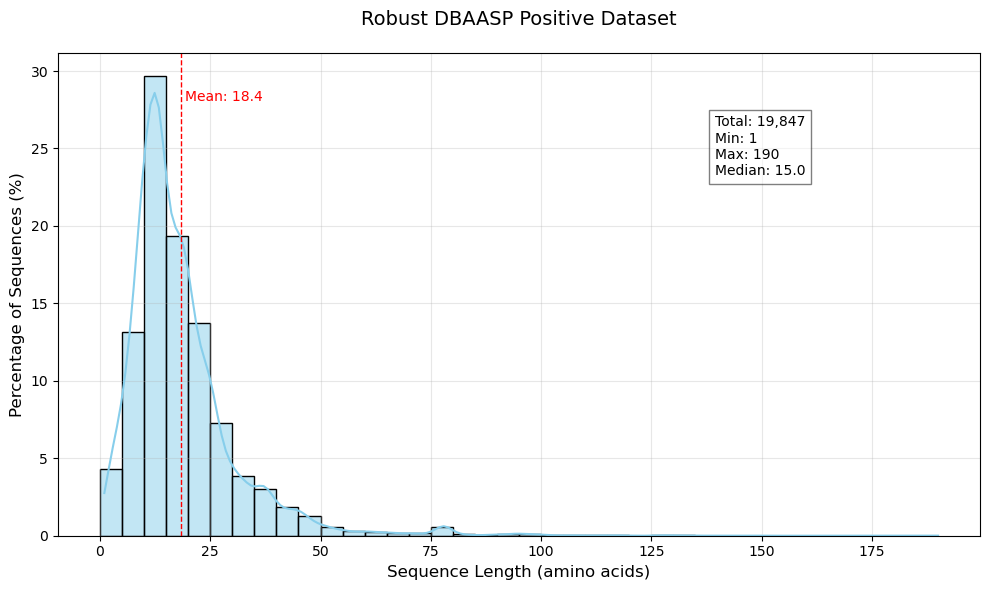

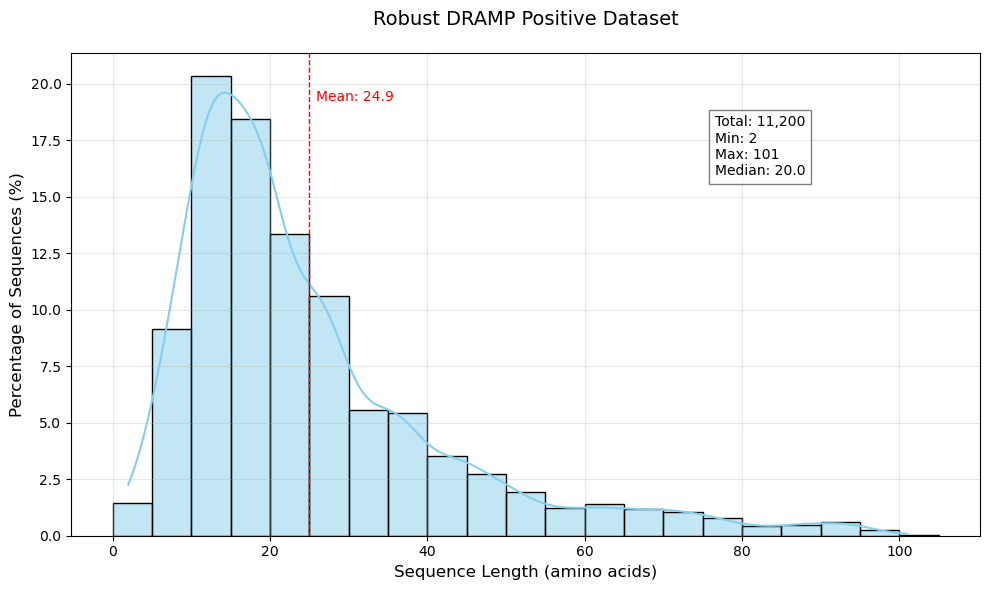

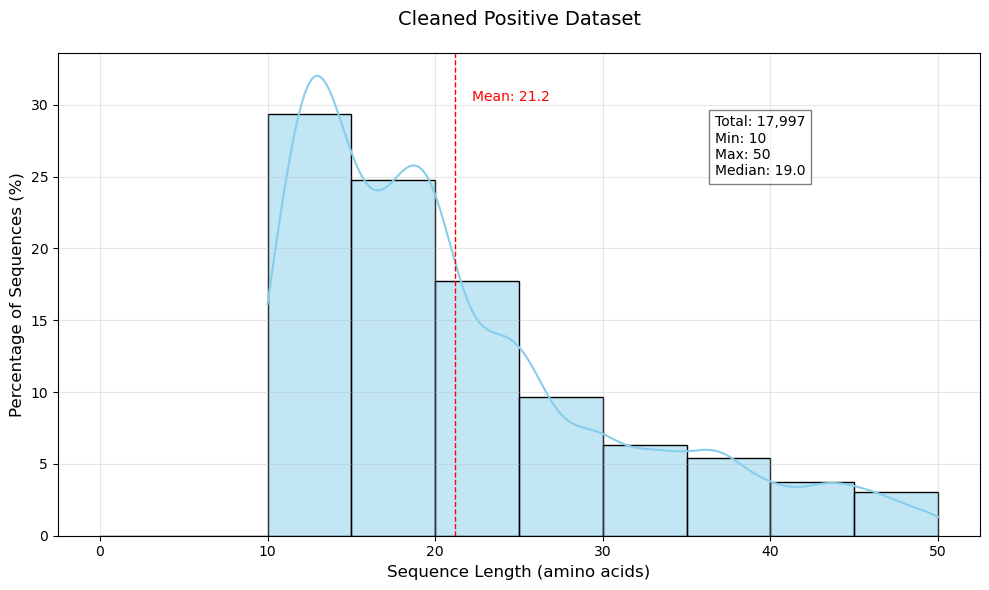

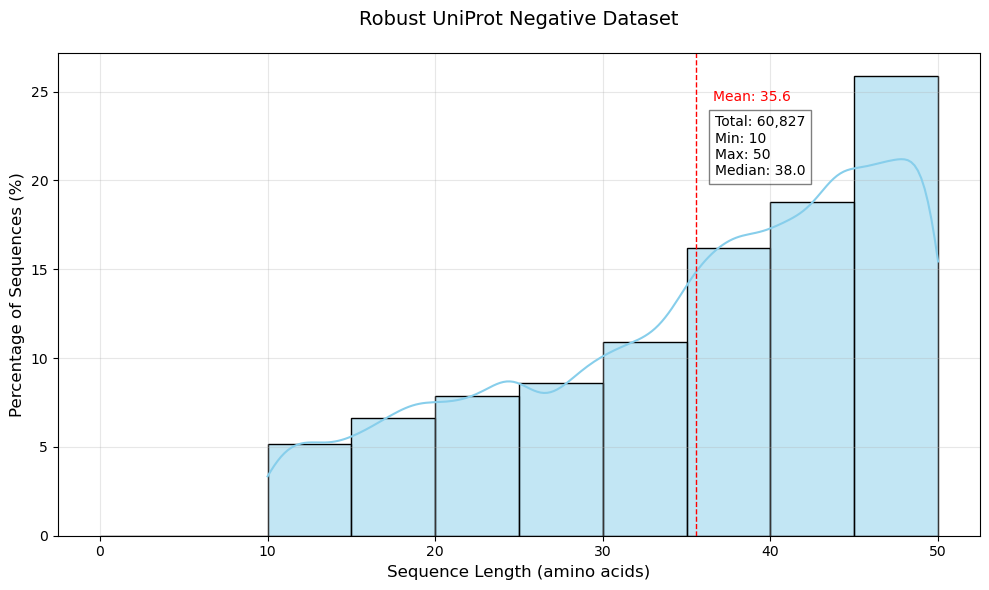

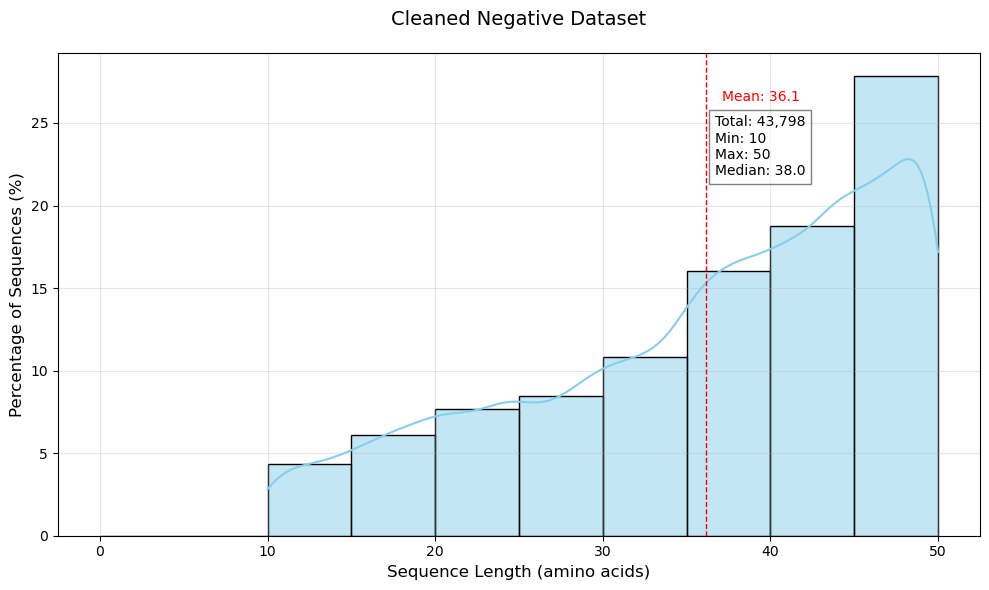

In [446]:
dfs = [
    (dbamp_df, 'Sequence', 'Robust DBAMP Positive Dataset'), (dbaasp_df, 'SEQUENCE', 'Robust DBAASP Positive Dataset'), (antib_dramp_df, 'Sequence', 'Robust DRAMP Positive Dataset'), (positive_amps_df, 'SEQUENCE', 'Cleaned Positive Dataset'), (up_amps_df, 'Sequence', 'Robust UniProt Negative Dataset'), (negative_amps_df, 'SEQUENCE', 'Cleaned Negative Dataset')]

for i, (df, name_col, df_title) in enumerate(dfs, 1):
    plot_sequence_length_distribution(df, sequence_col=name_col, title=df_title)

Showing the aa composition diagram

In [448]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def plot_aa_composition(*datasets, names=None, title='Amino Acid Composition',figsize=(15, 8),save_dir='figures'):
    """
    Plots amino acid composition diagrams for multiple datasets.
    
    Args:
        *datasets: Variable number of DataFrames containing 'SEQUENCE' column
        names: List of names for each dataset (for legend)
        figsize: Figure size (width, height)
    """
    sns.set_palette("husl")
    os.makedirs(save_dir, exist_ok=True)
    
    plt.figure(figsize=figsize)
    std_aas = "ACDEFGHIKLMNPQRSTVWY"
    
    for i, df in enumerate(datasets):
        
        aa_counts = Counter("".join(df['SEQUENCE'].dropna().str.upper()))
        total = sum(aa_counts.values())
        
        freqs = {aa: aa_counts.get(aa, 0)/total for aa in std_aas}
        
        plot_data = pd.DataFrame({
            'Amino Acid': list(freqs.keys()),
            'Frequency': list(freqs.values()),
            'Dataset': names[i] if names else f'Dataset {i+1}'
        })
        
        sns.barplot(data=plot_data, x='Amino Acid', y='Frequency', 
                   hue='Dataset', alpha=0.7 if len(datasets)>1 else 1.0)
        
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Amino Acid', fontsize=14)
    plt.ylabel('Relative Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)
    
    
    plt.legend(fontsize=12)
    plt.tight_layout()

    filename = f"{title.lower().replace(' ', '_')}.png"
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

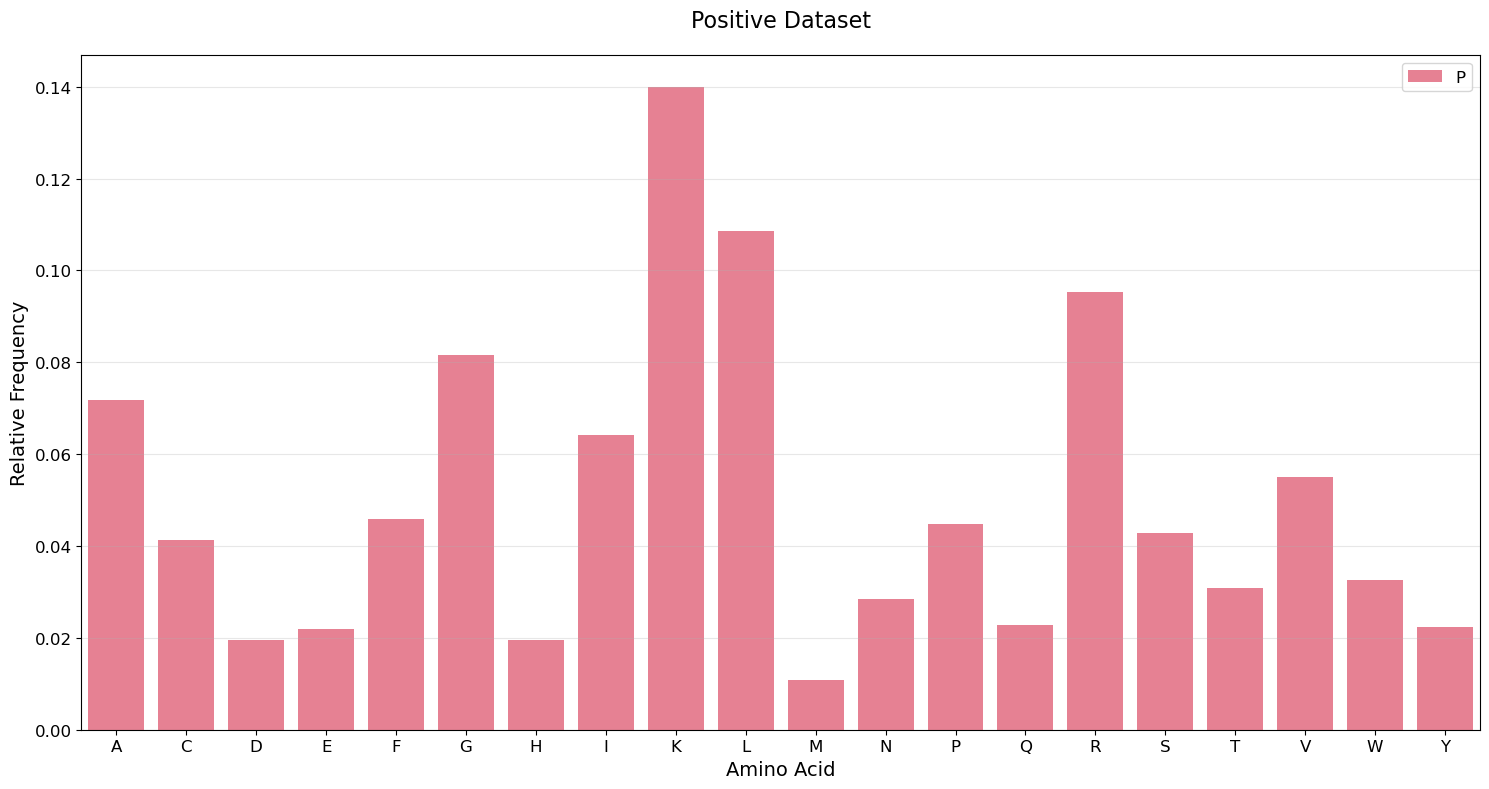

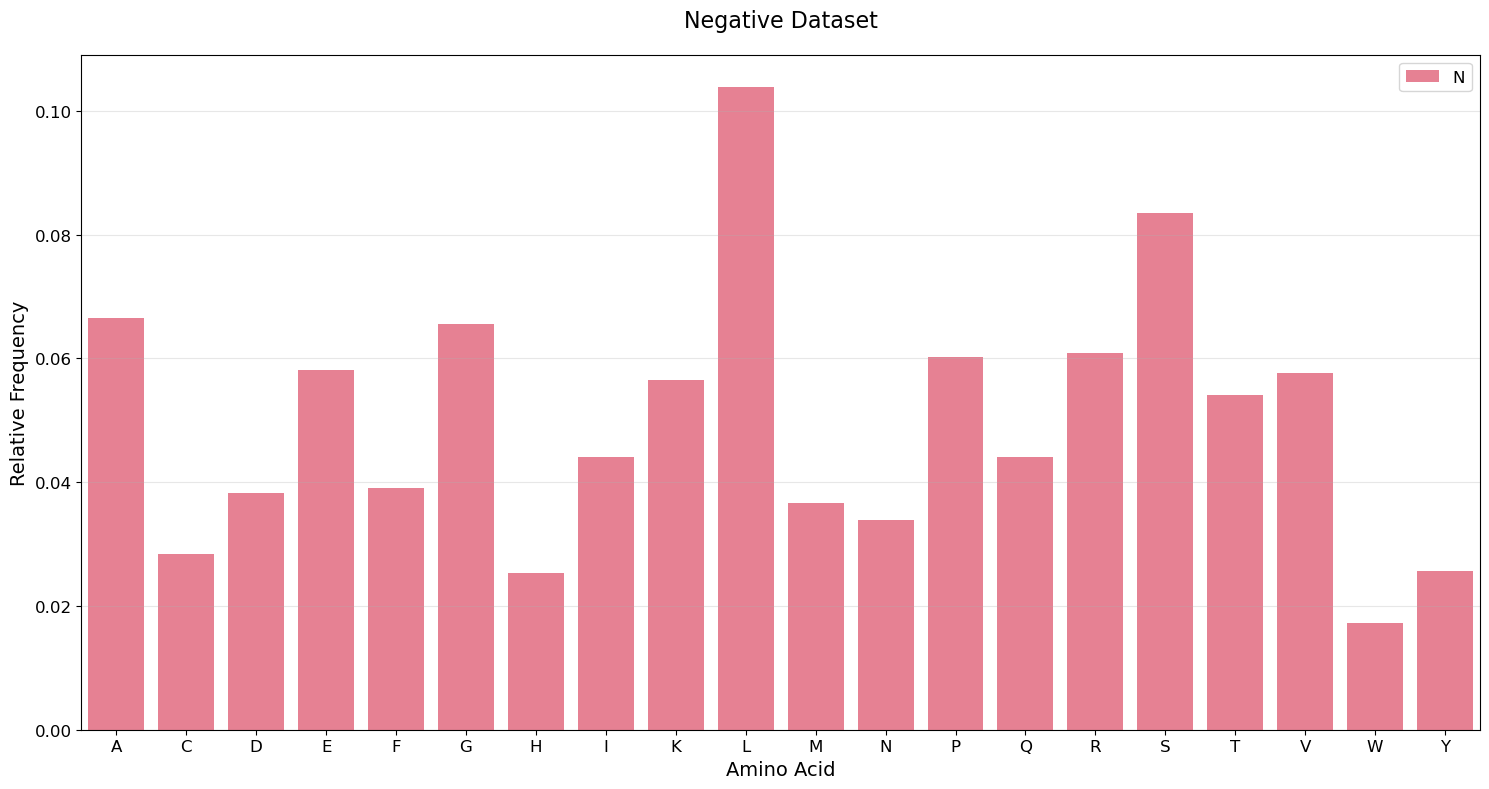

In [449]:
dfs = [(positive_amps_df, 'Positive Dataset'), (negative_amps_df, 'Negative Dataset')]
for (df, ds_name) in dfs:
    plot_aa_composition(df, names=ds_name, title=ds_name)

Combining positive and negative datasets

In [451]:
amps_dataset = pd.concat([positive_amps_df, negative_amps_df], axis=0)

Adding information about proteins with a use of biopython

In [453]:
from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def analyze_sequence(sequence):
    """Calculate various protein properties for a given sequence"""
    try:
        prot = ProteinAnalysis(sequence)
        return {
            'molecular_weight': molecular_weight(sequence, seq_type="protein"),
            'isoelectric_point': prot.isoelectric_point(),
            'gravy': prot.gravy(),
            'instability_index': prot.instability_index(),
        }
    except Exception as e:
        print(f"Error analyzing sequence {sequence[:10]}...: {e}")
        return None

# Apply analysis to each sequence in DataFrame
def add_protein_properties(df, sequence_col='SEQUENCE'):
    """
    Add protein properties as new columns to DataFrame
    Args:
        df: Input DataFrame containing sequences
        sequence_col: Name of column containing protein sequences
    Returns:
        DataFrame with added properties
    """
    # Create temporary analysis DataFrame
    analyses = df[sequence_col].apply(analyze_sequence)
    analyses_df = pd.json_normalize(analyses.dropna())
    
    # Combine with original data
    result_df = pd.concat([df.reset_index(drop=True), 
                         analyses_df.reset_index(drop=True)], axis=1)
    
    return result_df

amps_dataset = add_protein_properties(amps_dataset)

Creating a tsv file of combined dataset

In [455]:

amps_dataset.to_csv('amps_dataset.tsv', sep='\t', index=False)